---
# **Speech Emotion Recognition** - Using Voice Clips to Identify User Sentiment with Python
---

## Flatiron School - Data Science Capstone Project
### Code by Nicholas Wertz


<img src="images/reference/Banner_1.png" alt="The Metaverse" style="width: 1000px;"/>
<br>

---

## Table of Contents
1. [Business Understanding](#1.-Business-Understanding)
2. [Data Understanding](#2.-Data-Understanding)
3. [Data Preparation](#3.-Data-Preparation)
4. [Modeling](#4.-Modeling)
5. [Evaluation](#5.-Evaluation)
6. [Appendix](#6.-Appendix)

---
# 1. Business Understanding 

With the recent surge of popularity of Virtual Reality chat rooms, such as Meta's Horizon Worlds, there have been more people using online avatars in live chats. Whether the reason is for privacy or simple fun, more people are using  avatars to represent themselves in calls. However, emotional expression is lost as these avatars cannot currently retain a static expression chosen upon creation, and do not actively reflect the emotional states of users. With this disconnect of emotion to expression, users are more distant from each-other, less engaged with content, and therefore, less loyal to a particular service. 

By implementing real time audio emotion tracking, and mapping the results to users' avatars, we can increase engagement from user to user and foster a greater sense of community within your platform, and therefore build greater customer loyalty.

---
# 2. Data Understanding

All voice data clips used were provided by [The Emotional Voices Database (EmoV-DB)](https://arxiv.org/abs/1806.09514), an open-sourced emotional speech database intended to to be used for synthesis and generation of emotion detection and simulation programs. This dataset consists of audio recordings of 5 actors (4 in English and 1 in French) speaking phrases simulating once of 5 possible emotions. The emotions of simulated by the actors were: Anger, Amusement, Disgust, Neutral, Sleepiness. To avoid an imbalance due to their being only 1 French speaking actor in the dataset, I only utilized the recordings of the 4 English speaking actors. The English EmoV-DB files  can be found [at this link.](https://mega.nz/folder/KBp32apT#gLIgyWf9iQ-yqnWFUFuUHg/folder/mYwUnI4K)

Now that we have identified what dataset we are going to use , let's import all required libraries and packages. Keras and Google Colab related imports were put in their own cell due to them only working when running in Colab.

In [10]:
#Google Colab Imports
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/SER_Capstone/


#Keras Imports (Only Worked In Colab)
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.models import Model
from keras.metrics import Recall
from tensorflow.keras.optimizers import Adam 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/SER_Capstone


In [1]:
#Standard Python Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Model Creation/Evaluation Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Audio Data Manipulation Imports
import random
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd

#File Path Navigation Import
import os

#Model Saving Import
import pickle

#Preventative Import
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


## Importing the Dataset

After downloading the Dataset, all files were in a folder named `EmoV-DB_sorted`, located in the same directory on my local machine as this Jupyter Notebook. I logged all the sound clip file paths, the actors for each sound clip, the sex of the actors, and the emotions expressed in each clip. This information was all saved as a pandas DataFrame, named `df`.

In [2]:
Emo_path = 'EmoV-DB_sorted/' #the folder containing all subfolders
emo_actor_list = os.listdir(Emo_path) 
emo_actor_list.sort

file_actor = []
file_emotion = []
file_path = []

for dir in emo_actor_list:  #each subfolder on this level is the name of the actor
    if dir.startswith('.'): #put in due to .DS
        pass
    else:
        actor = os.listdir(Emo_path + dir) 
    
        for emotions in actor: #each subfolder on this level is the name of the emotion files
            if emotions.startswith('.'):
                pass
            else:
                 
                emotion = os.listdir(Emo_path + dir + '/' + emotions) 
                for file in emotion:  # sound files in alphanumeric order
                    if file.startswith('.'):
                        pass
                    else:
                        file_emotion.append(emotions.lower())
                        file_path.append(Emo_path + dir + '/' + emotions  + '/' + file)
                        file_actor.append(dir)
     

In [3]:
print(f'Number of file paths: {len(file_path)},\
      Number of emotions listed: {len(file_emotion)},\
      Number of actors listed: {len(file_actor)}')

Number of file paths: 6893,      Number of emotions listed: 6893,      Number of actors listed: 6893


In [4]:
df = pd.DataFrame({"file_path" : file_path, "actor" : file_actor})
df["sex"] = df["actor"].apply(lambda x: "female" if x in ["jenie", "bea"] else 'male')
df["emotion"] = (file_emotion)

df

,file_path,actor,sex,emotion
0,EmoV-DB_sorted/sam/Amused/sam_amused_00058.wav,sam,male,amused
1,EmoV-DB_sorted/sam/Amused/sam_amused_00064.wav,sam,male,amused
2,EmoV-DB_sorted/sam/Amused/sam_amused_00070.wav,sam,male,amused
3,EmoV-DB_sorted/sam/Amused/sam_amused_00299.wav,sam,male,amused
4,EmoV-DB_sorted/sam/Amused/sam_amused_00266.wav,sam,male,amused
...,...,...,...,...
6888,EmoV-DB_sorted/josh/Sleepy/josh_sleepy00154.wav,josh,male,sleepy
6889,EmoV-DB_sorted/josh/Sleepy/josh_sleepy00140.wav,josh,male,sleepy
6890,EmoV-DB_sorted/josh/Sleepy/josh_sleepy00168.wav,josh,male,sleepy
6891,EmoV-DB_sorted/josh/Sleepy/josh_sleepy00197.wav,josh,male,sleepy


As you can see there are a total of 6,893 sound files of English speakers in the EmoV-DB dataset. Let's check how many clips of each emotion exist in our data.

In [5]:
df.emotion.value_counts()

sleepy       1721
neutral      1568
amused       1317
angry        1268
disgusted    1019
Name: emotion, dtype: int64

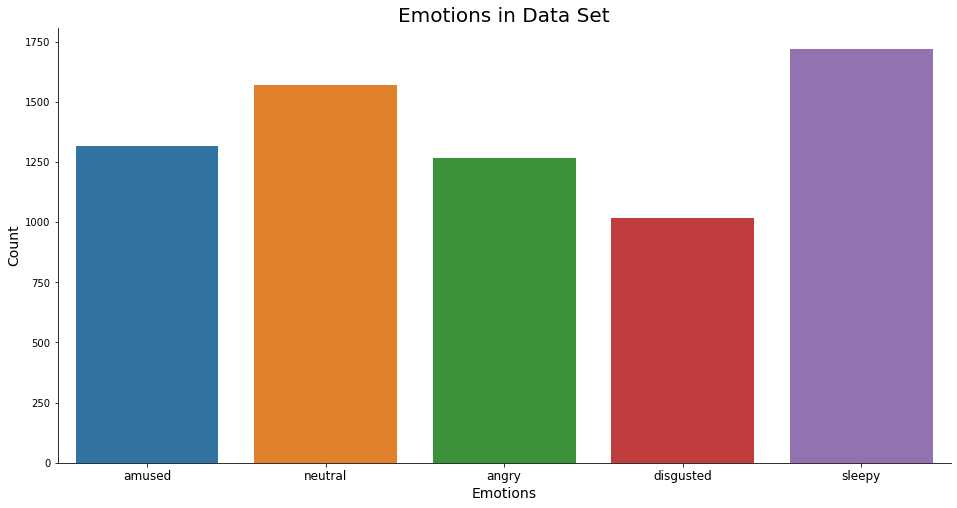

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(df.emotion)
plt.title('Emotions in Data Set', size=20)
plt.ylabel('Count', size=14)
plt.xlabel('Emotions', size=14)
plt.xticks(size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
# plt.savefig('img/plots/Emotion_count')
plt.show()

As you can see, our data set does not have an even number of all emotions expressed. Sleepiness has the most representation, with over 1700 files, and disgust has the least with just over 1000. While this is a slight imbalance, I do not believe it will massively affect our modeling process.

Next, let's look at the actors who recorded our data.

sam      2453
jenie    1790
bea      1787
josh      863
Name: actor, dtype: int64


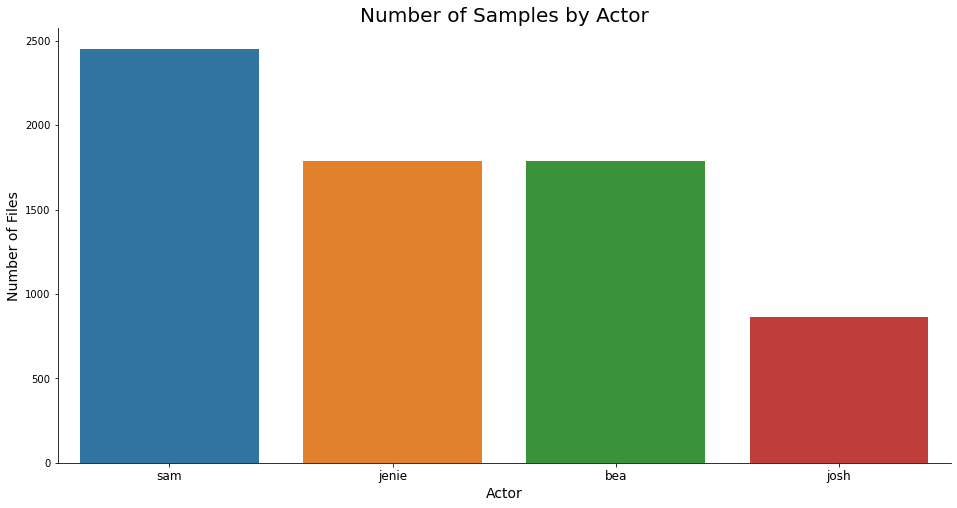

In [7]:
print(df.actor.value_counts())

fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(df.actor)
plt.title('Number of Samples by Actor', size=20)
plt.ylabel('Number of Files', size=14)
plt.xlabel('Actor', size=14)
plt.xticks(size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
# plt.savefig('img/plots/Actor_count')
plt.show()

Jenie and Bea both have recorded almost 1800 clips each, while Josh only recorded 863. However, Sam recorded nearly 2500 clips to prevent an imbalance.

female    3577
male      3316
Name: sex, dtype: int64


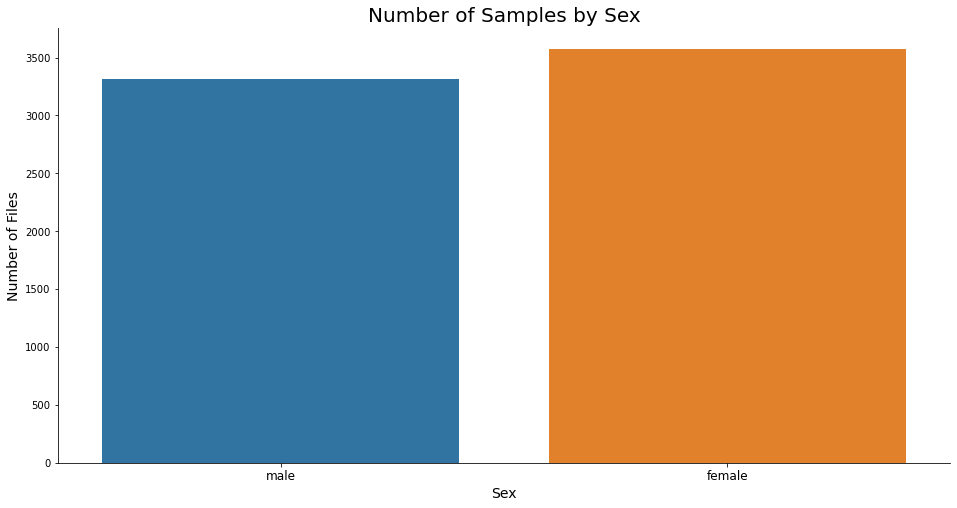

In [8]:
print(df.sex.value_counts())

fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(df.sex)
plt.title('Number of Samples by Sex', size=20)
plt.ylabel('Number of Files', size=14)
plt.xlabel('Sex', size=14)
plt.xticks(size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
# plt.savefig('img/plots/sex_count')
plt.show()

As you can see, Sam was really able to pick up the slack. The number of sound clips recorded between sexes is fairly even with only about 250 more female files. 

Now that we the file paths for all available data, let's take a look at how we will prepare our data for training a Convolutional Neural Network model.

---
# 3. Data Preparation 

Before we process all files, let's take a high level look of what exactly we are doing to each audio file. We will start by looking at a single audio file.

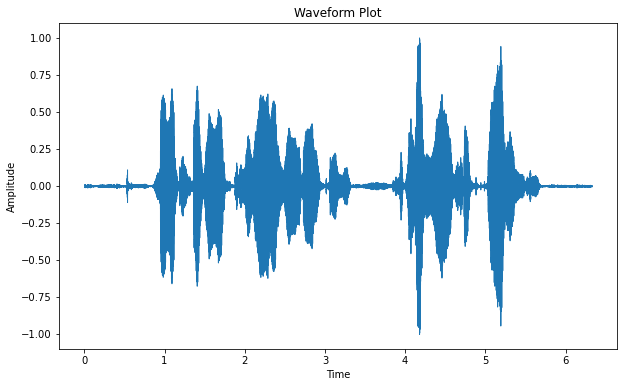

In [9]:
file_name='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'



audio_data, sampling_rate = librosa.load(file_name)
fig, ax = plt.subplots(figsize=(10,6))
librosa.display.waveshow(audio_data,sr=sampling_rate)
ax.set(title='Waveform Plot', ylabel='Amplitude')
ax.label_outer();
# plt.savefig('img/waveforms/sam_amused_00003.wav') #Commented Out as to Not Overwrite Current File

Looking at this one audio file, we can already see that there "dead zones" with no audio at the beginning and end of our files. This will need to be removed on all files so we do not waste time analyzing what is essentially silence. <br>
Now let's look at a better visual representation of our audio file above using `librosa`'s `melspectrogram` and `specshow` to create a Mel Spectrogram.

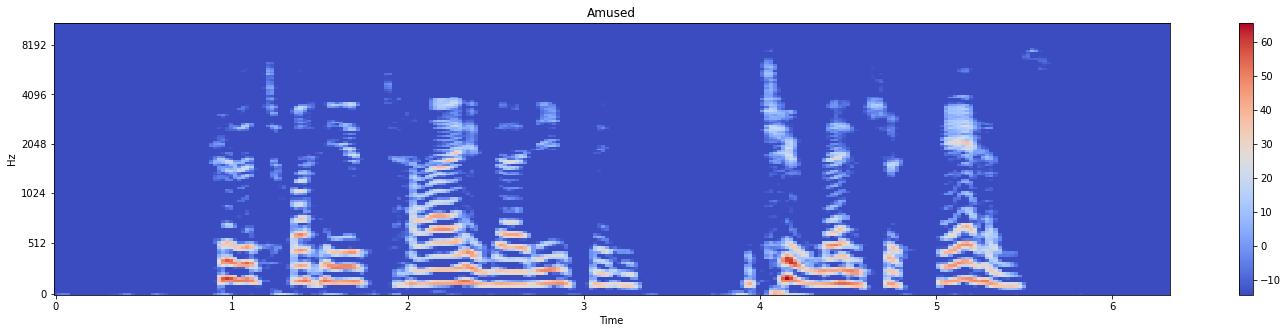

In [11]:
# Creating a basic Mel Spectrogram from our audio sample above 
spectrogram = librosa.feature.melspectrogram(audio_data)
s_db = librosa.amplitude_to_db(spectrogram)
fig, ax = plt.subplots(figsize=(25, 5))

amuse = librosa.display.specshow(s_db, sr=sampling_rate, x_axis='time', y_axis='mel', ax=ax)
ax.set(title="Amused")
fig.colorbar(amuse, ax=ax);
# plt.savefig('img/waveforms/sam_amused_00003_specro') #Commented Out as to Not Overwrite Current File

A Mel Spectrogram is a representation of an audio signal converted to the "Mel Scale", a scale of frequency that is more representative of human hearing. Our `librosa` functions have essentially done three transformations to our audio file. First, it performs a fast Fourier transform to analyze the frequency content of a signal over time. `Librosa` then converts these frequencies to the Mel scale, before finally plotting our mel spectrogram of our audio signal over time. The distinct visual patterns of the resulting Mel Spectrogram are what I plan to feed into our CNN to train our model. <br>

<img src="images/reference/Mel_scale.png" alt="Mel Scale" style="width: 400px;"/>

<br>
As you saw before, much of our audio file is empty space that must be trimmed, but from this visual we can see that our audio file is fairly long. If all of our files vary in length, this could lead to issues with training.

#### However, if once we trim our silence, we divide our remaining audio files into shorter clips we will fix this issue. There is also an added bonus of our audio files being shorter; if we use our predictive model on live audio, we will have a faster processing time for our model thus the emotion state of each user will update faster.

---
## Trimming Silence from Audio Files

We will now remove any silence in the beginning and end of the audio clips and save these new files to the folder trimmed_audio

In [ ]:
def the_trimmer(path):
    
    #Preparing path to be reused as new file name
    path_stripped = os.path.basename(path).strip(".wav") 
    #Original audio data
    audio_data_test, sampling_rate_test = librosa.load(path)
   
    # Any audio under 30dB to be ignored   
    audio_data_test2, index = librosa.effects.trim(audio_data_test, top_db = 30.0 ) 
    
    #Writing the new audio file in a new location
    sf.write(f'trimmed_audio/{path_stripped}.wav', audio_data_test2, sampling_rate_test, format='wav')

In [ ]:
# df["file_path"].apply(lambda x: the_trimmer(x))  #Commented out as not to affect future runs

Now that we have trimmed our silence we will log all paths in this folder in the same way we did before.

In [10]:
pathway = 'trimmed_audio/'
path_list = os.listdir(pathway) 


file_path_trimmed = []

for file in path_list:
    if file.startswith('.'):
        pass
    else:
        file_path_trimmed.append(pathway + file)
     

In [11]:
len(file_path_trimmed)

6733

Then we create a new dataframe for out newly trimmed audio's paths.

In [ ]:
trimmed_audio_df = pd.DataFrame(file_path_trimmed, columns = {"trimmed_paths"} )
trimmed_audio_df

,trimmed_paths
0,trimmed_audio/bea_angry_00235.wav
1,trimmed_audio/bea_angry_00179.wav
2,trimmed_audio/bea_angry_00150.wav
3,trimmed_audio/bea_angry_00274.wav
4,trimmed_audio/bea_angry_00099.wav
...,...
6728,trimmed_audio/sam_sleepy_00469.wav
6729,trimmed_audio/sam_sleepy_00198.wav
6730,trimmed_audio/sam_sleepy_00491.wav
6731,trimmed_audio/sam_sleepy_00045.wav


---
## Splitting Our Audio Files into Smaller Lengths
As previously stated, we want our audio files at a fairly consistent length to train our model as effectively as possible. I decided on 2 seconds as the ideal length and set about creating a function that will got to each trimmed audio file path, read through the audio 2 seconds at a time, and save each newly created file to a new folder.

In [ ]:
def the_chopper(path):
    path_stripped = os.path.basename(path).strip(".wav")
    data, sr = sf.read(path)
    split = []
    noSections = int(np.ceil(len(data) / sr)) #running length of each audio file

    for i in range(noSections):
        temp = data[i*sr:i*sr + sr*2] #[from start point: starting point + 2 seconds]
        split.append(temp)
    
    
    for i in range(noSections)[::2]: #writing every other file to avoid 1 second overlaps
        filename = f"chopped_wavs/{path_stripped}_chopped{i}.wav"
        sf.write(filename, split[i], sr)
 
      

In [ ]:
# trimmed_audio_df["trimmed_paths"].apply(lambda x: the_chopper(x)) ##Commented out as not to affect future runs

Reading through our new folder and creating a data frame, just as we did before.

In [12]:
pathway = 'chopped_wavs/'
pathway_to_files = os.listdir(pathway) 


file_path_chop = []

for file in pathway_to_files:
    if file.startswith('.'):
        pass
    else:
        file_path_chop.append(pathway + file)
    
        
     

In [13]:
len(file_path_chop)

16833

In [ ]:
chopped_audio_df = pd.DataFrame(file_path_chop, columns = {"chopped_paths"} )
chopped_audio_df

,chopped_paths
0,chopped_wavs/josh_sleepy00175_chopped0.wav
1,chopped_wavs/josh_sleepy00175_chopped2.wav
2,chopped_wavs/josh_sleepy00175_chopped4.wav
3,chopped_wavs/josh_sleepy00048_chopped0.wav
4,chopped_wavs/josh_sleepy00048_chopped2.wav
...,...
16828,chopped_wavs/sam_sleepy_00454_chopped0.wav
16829,chopped_wavs/sam_sleepy_00454_chopped2.wav
16830,chopped_wavs/sam_sleepy_00454_chopped4.wav
16831,chopped_wavs/sam_sleepy_00454_chopped6.wav


We now have a dataset of 16,833 audio files to use for training our dataset!

---
## Creating Our Train/Test Split

Now that we have all the files we want for modeling, we will perform a standard `train_test_spit` on our files and create a training and testing dataframe of file paths.

In [ ]:
X_train, X_test = train_test_split(chopped_audio_df["chopped_paths"], test_size=0.25, random_state=42, shuffle = True)


In [ ]:
X_train_df = pd.DataFrame(X_train, columns = {"chopped_paths"} )
X_test_df = pd.DataFrame(X_test, columns = {"chopped_paths"} )


In [ ]:
X_train_df

,chopped_paths
6840,chopped_wavs/bea_amused_00113_chopped0.wav
10144,chopped_wavs/sam_amused_00215_chopped2.wav
7592,chopped_wavs/jenie_sleepy_00218_chopped0.wav
2412,chopped_wavs/bea_sleepy_00046_chopped4.wav
9707,chopped_wavs/jenie_disgusted_00164_chopped2.wav
...,...
11284,chopped_wavs/sam_amused_00373_chopped2.wav
11964,chopped_wavs/sam_amused_00151_chopped4.wav
5390,chopped_wavs/bea_neutral_00093_chopped2.wav
860,chopped_wavs/josh_amused00298_chopped0.wav


In [ ]:
X_test_df

,chopped_paths
1302,chopped_wavs/josh_neutral00007_chopped2.wav
736,chopped_wavs/josh_amused00095_chopped0.wav
10359,chopped_wavs/jenie_anger_00114_chopped0.wav
4625,chopped_wavs/bea_disgusted_00198_chopped4.wav
13818,chopped_wavs/sam_disgust_00072_chopped2.wav
...,...
2753,chopped_wavs/bea_angry_00143_chopped2.wav
12293,chopped_wavs/sam_disgust_00396_chopped6.wav
14739,chopped_wavs/sam_angry_00457_chopped2.wav
13872,chopped_wavs/sam_disgust_00105_chopped4.wav


---
## Data Augmentation

Now that we have performed our train_test_split, we will move on to augmentation of the data. 
Our X_test data will remain as is, as we simply want to see how our model performs on fairly clean data. The testing files will simply be copied to a new folder before creating spectrograms of each audio clip. <br>

#### All of the data in our X_train dataframe will be augmented in order to introduce random noise, speed, and pitch variability. This will be in order to simulate the variability of human voices and recording equipment in an attempt to further generalize our training data. 



Below are the functions created to augment our X_train audio files. The `noise`, `speed_random`, and `pitch` functions will introduce a randomized amount of their specific augmentation to each audio file when utilized by the `augmentation` function before being written to the `aug_train_wavs` folder. The `copier` function simply will copy all files in the X_test data to the `test_wavs` folder.

In [ ]:
def noise(data):
    amplitude = 0.015*np.random.uniform()*np.amax(data)
    data = data + amplitude*np.random.normal(size=data.shape[0])
    return data

def speed_random(data):
    random_rate = round(random.uniform(0.9, 1.1), 2)
    spedup = librosa.effects.time_stretch(data, random_rate)
    return spedup

def pitch(data, sampling_rate):
    random_pitch = round(random.uniform(.85, 1.15), 2)
    pitched = librosa.effects.pitch_shift(data, sampling_rate, random_pitch)
    return pitched

def augmentation(path):  #Code augment and write augmented X_train files to a new folder
    path_stripped = os.path.basename(path).strip(".wav")
    audio_data, sampling_rate = librosa.load(path)  
    noised = noise(audio_data)
    sped = speed_random(noised)
    pitcher = pitch(sped, sampling_rate)
    sf.write(f'aug_train_wavs/{path_stripped}.wav', pitcher, sampling_rate, format='wav')
    return

def copier(path):   #Code to copy all X_test files to a new folder
    path_stripped = os.path.basename(path).strip(".wav")
    audio_data, sampling_rate = librosa.load(path)
    sf.write(f'test_wavs/{path_stripped}.wav', audio_data, sampling_rate, format='wav')


#### Random Noise Test

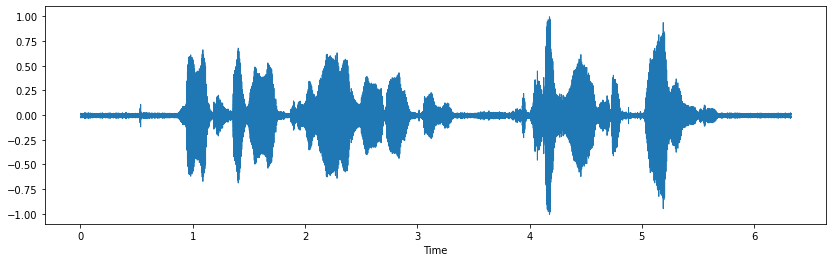

In [ ]:
file_name='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'



audio_data, sampling_rate = librosa.load(file_name)

x = noise(audio_data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)

ipd.Audio(x, rate=sampling_rate)

#### Random Speed Modifier Test

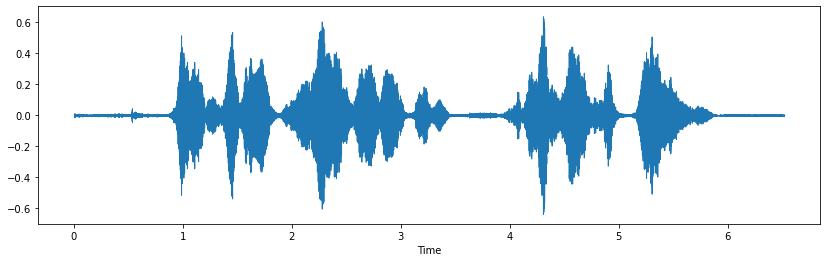

In [ ]:
file_name='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'



audio_data, sampling_rate = librosa.load(file_name)

x = speed_random(audio_data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)

ipd.Audio(x, rate=sampling_rate)

#### Random Pitch Adjustment Test

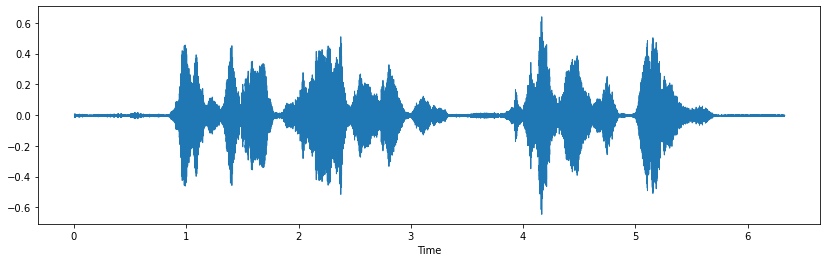

In [ ]:
file_name='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'



audio_data, sampling_rate = librosa.load(file_name)

x = pitch(audio_data, sampling_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sampling_rate)

ipd.Audio(x, rate=sampling_rate)

#### Augmentation Function Test

In [ ]:
# file_name='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'

# augmentation(file_name) #Commented out as not to affect future runs

#### Modifying and Writing New Audio Files

In [ ]:
# X_test_df["chopped_paths"].apply(lambda x: copier(x)) #Commented out as not to affect future runs

In [ ]:
# X_train_df["chopped_paths"].apply(lambda x: augmentation(x)) #Commented out as not to affect future runs


---
### Logging All New File Pathways
We will once again log the file paths of our X_train and X_test data so that we can create data frames and apply a lambda function in oder to create our spectrograms for modeling

In [14]:
pathway = 'aug_train_wavs/'
pathway_to_files = os.listdir(pathway) 


train_paths = []

for file in pathway_to_files:
    if file.startswith('.'):
        pass
    else:
        train_paths.append(pathway + file)
    
        
len(train_paths)

12624

In [15]:
train_aug = pd.DataFrame(train_paths, columns = {"train_paths"} )
train_aug


,train_paths
0,aug_train_wavs/bea_sleepy_00027_chopped0.wav
1,aug_train_wavs/josh_sleepy00005_chopped2.wav
2,aug_train_wavs/jenie_sleepy_00157_chopped0.wav
3,aug_train_wavs/bea_neutral_00062_chopped2.wav
4,aug_train_wavs/bea_sleepy_00072_chopped0.wav
...,...
12619,aug_train_wavs/josh_sleepy00088_chopped4.wav
12620,aug_train_wavs/bea_sleepy_00014_chopped0.wav
12621,aug_train_wavs/josh_sleepy00036_chopped2.wav
12622,aug_train_wavs/sam_sleepy_00386_chopped0.wav


In [7]:
pathway = 'test_wavs/'
pathway_to_files = os.listdir(pathway) 


test_paths = []

for dir in emo_actor_list:
    if dir.startswith('.'):
        pass
    else:
        actor = os.listdir(Emo_path + dir) 


for file in pathway_to_files:
    if file.startswith('.'):
        pass
    else:
        test_paths.append(pathway + file)
    
        
len(test_paths)

4209

In [8]:
test_no_aug = pd.DataFrame(test_paths, columns = {"test_paths"} )
test_no_aug

,test_paths
0,test_wavs/sam_neutral_00400_chopped0.wav
1,test_wavs/bea_amused_00289_chopped0.wav
2,test_wavs/jenie_neutral_00189_chopped0.wav
3,test_wavs/bea_amused_00276_chopped0.wav
4,test_wavs/jenie_neutral_00123_chopped0.wav
...,...
4204,test_wavs/bea_neutral_00004_chopped2.wav
4205,test_wavs/sam_neutral_00433_chopped0.wav
4206,test_wavs/jenie_sleepy_00164_chopped0.wav
4207,test_wavs/sam_amused_00128_chopped0.wav


#### We have not lost any of our data when augmenting or copying! Now that we have all of our file path names we can finally create spectrograms from each audio clip.

---
### Creating Spectrograms for CNN Model Training and Testing

We will modify our code from earlier to create a simple spectrogram from each file path we feed into our program. We will then save our spectrograms in newly created folders `test_spectro` and `train_spectro` depending on which dataframe our source is coming from. 

In [ ]:
def spectrogrammer(path, new_folder_name):
    os.path.basename(path)
    path_stripped = os.path.basename(path).strip(".wav")
    
    audio_data, sampling_rate = librosa.load(path)
    
    spectro = librosa.feature.melspectrogram(audio_data)
    
    s_db = librosa.amplitude_to_db(spectro)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    new_s = librosa.display.specshow(s_db, sr=sampling_rate, ax=ax)
    
    
#     fig.colorbar(new_s, ax=ax) # good for single analysis but will get confused in CNN 
  
    new_path = (new_folder_name + '/' + path_stripped +'.png')
    plt.savefig(new_path)
    return

#### Testing Our Spectrogram Writer

In [ ]:
og_path ='EmoV-DB_sorted/sam/Amused/sam_amused_00003.wav'

# spectrogrammer(og_path, "test_spectro")  ##Commented out as not to affect future runs

---
### Applying the Spectrogrammer to the Training Data

In [ ]:
# train_aug["train_paths"].apply(lambda x: spectrogrammer(x,"train_spectro"))

##Commented out as not to affect future runs


In [ ]:
pathway = 'train_spectro/'
pathway_to_files = os.listdir(pathway) 
pathway_to_files.sort

train_spectro_list = []
train_emotion = []

for folder in pathway_to_files:
    if folder.startswith('.'):
        pass
    else:
        emotion = os.listdir(pathway + folder) 
        for file in emotion:
            if file.startswith('.'):
                pass
            else:
                train_emotion.append(folder)
                train_spectro_list.append(pathway + folder  + '/' + file)

len(train_spectro_list)

12577

---
### Applying the Spectrogrammer to the Test Data

In [ ]:
# test_no_aug["test_paths"].apply(lambda x: spectrogrammer(x,"test_spectro"))

##Commented out as not to affect future runs

In [ ]:
pathway = 'test_spectro/'
pathway_to_files = os.listdir(pathway) 
pathway_to_files.sort

test_spectro_list = []
test_emotion = []

for folder in pathway_to_files:
    if folder.startswith('.'):
        pass
    else:
        emotion = os.listdir(pathway + folder) 
        for file in emotion:
            if file.startswith('.'):
                pass
            else:
                test_emotion.append(folder)
                test_spectro_list.append(pathway + folder  + '/' + file)

len(test_spectro_list)

4194

In [ ]:
test_df = pd.DataFrame({'paths':test_spectro_list, 'emotions': test_emotion})
test_df

,paths,emotions
0,test_spectro/Neutral/jenie_neutral_00189_chopp...,Neutral
1,test_spectro/Neutral/sam_neutral_00400_chopped...,Neutral
2,test_spectro/Neutral/sam_neutral_00324_chopped...,Neutral
3,test_spectro/Neutral/jenie_neutral_00123_chopp...,Neutral
4,test_spectro/Neutral/bea_neutral_00115_chopped...,Neutral
...,...,...
4189,test_spectro/Sleepiness/bea_sleepy_00085_chopp...,Sleepiness
4190,test_spectro/Sleepiness/bea_sleepy_00389_chopp...,Sleepiness
4191,test_spectro/Sleepiness/jenie_sleepy_00371_cho...,Sleepiness
4192,test_spectro/Sleepiness/bea_sleepy_00247_chopp...,Sleepiness


In [ ]:
test_df.emotions.value_counts()

Sleepiness    1299
Amusement      879
Disgust        748
Neutral        680
Anger          588
Name: emotions, dtype: int64

At this point, I performed manual sorting using MacOS's Finder to get each spectrum into a proper emotion folder. This was done in order to manually remove the occasional waveform tat appeared blank in the file's thumbnail.
These organized folders were then be uploaded to Google Drive in order to build a CNN model with Keras.

---
# 4. Modeling

For modeling, accuracy was the chosen metric, as it best represents when a file's emotional category was properly identified. For our multiclassification problem, when "accuracy is written as the metric, it is automatically switched to`tf.keras.metrics.CategoricalAccuracy` which calculates how often predictions match one-hot labels. <br>

However, we do still care about both our recall and precision, so we will combine both and look at the F1-Scores of models with high accuracy scores.  <br>

We will now define our training, validation, and testing data using keras's `ImageDataGenerator`.


In [12]:
classes = ["Amusement", "Anger", "Disgust", "Neutral", "Sleepiness"] #Class possiblities & names of our sorted folders
                                                                     #Keras uses these as our One-Hot labels

traingen = ImageDataGenerator(rescale=1/255, validation_split=0.10) #We are using a 10% validation set 
                                                                    #of our training set

testgen = ImageDataGenerator(rescale=1/255) #Our testing set remains 25% of our total dataset



train_data = traingen.flow_from_directory(
    directory='train_spectro/',
    target_size=(64, 64),
    classes = classes,
    class_mode='categorical',
    subset = "training",
    seed = 42
)
val_data = traingen.flow_from_directory(
    directory='train_spectro/',
    target_size=(64, 64),
    classes = classes,
    class_mode='categorical',
    subset = "validation",
    seed = 42
    )    
    
    
test_data = testgen.flow_from_directory(
    directory='test_spectro',
    target_size=(64, 64),
    classes = classes,
    class_mode='categorical',
    shuffle= False, #This is included as to not shuffle our testing data. Training and validation sets are shuffled
    seed = 42       #in order to make the training data more generalizable.
)


Found 11322 images belonging to 5 classes.
Found 1255 images belonging to 5 classes.
Found 4194 images belonging to 5 classes.


# Baseline Model

Let's create our baseline model. We will start with a 2D convolution layer, flatten it, and have a five node output layer, using a softmax activation function. As this is a baseline, we will only use one epoch for testing.

In [ ]:

baseline = tf.keras.models.Sequential()
baseline.add(tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
baseline.add(tf.keras.layers.Flatten())
baseline.add(tf.keras.layers.Dense(5, activation='softmax'))

baseline.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
baseline.summary()
baseline.fit(x=train_data, validation_data=val_data, epochs=1)



Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 62, 62, 10)        280       
                                                                 
 flatten_29 (Flatten)        (None, 38440)             0         
                                                                 
 dense_33 (Dense)            (None, 5)                 192205    
                                                                 
Total params: 192,485
Trainable params: 192,485
Non-trainable params: 0
_________________________________________________________________
354/354 [==============================] - 154s 433ms/step - loss: 1.5867 - accuracy: 0.4487 - val_loss: 1.3000 - val_accuracy: 0.4956


In [ ]:
filename = 'baseline_model.pkl'
pickle.dump(baseline, open(filename, 'wb'))


INFO:tensorflow:Assets written to: ram://470bf695-fba1-4697-bfe5-fdad807e4335/assets


In [ ]:
baseline.evaluate(test_data)

132/132 [==============================] - 48s 363ms/step - loss: 1.1879 - accuracy: 0.5122


[1.1878958940505981, 0.5121602416038513]

With a very basic model, we are already able to reach 51% accuracy! For a multiclassification problem this is an excellent place to begin.

# Model 1

We will add an additional 2D convolution layer and a Max Pooling layer as well increase our number of filters.

In [ ]:
model_1 = tf.keras.models.Sequential()
model_1.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model_1.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_1.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(5, activation='softmax'))


model_1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_1.summary()
model_1.fit(x=train_data, validation_data=val_data, epochs=1)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 31, 31, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 flatten_30 (Flatten)        (None, 29435)             0         
                                                                 
 dense_34 (Dense)            (None, 5)                 147180    
                                                                 
Total params: 171,225
Trainable params: 171,225
Non-trainable params: 0
_______________________________________________

In [ ]:
filename = 'model_1.pkl'
pickle.dump(model_1, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://805f0db8-2811-4342-aaaf-6b91e6beddd8/assets


In [ ]:
model_1.evaluate(test_data)

132/132 [==============================] - 49s 374ms/step - loss: 1.1478 - accuracy: 0.5150


[1.147836685180664, 0.5150214433670044]

We have not made improvement to our testing accuracy or our loss, with both improvements being so small they could be mistaken for rounding errors. However, more layers is likely going to help us, so Model 1 will be the basis for our next model.

# Model 2

To see what improvements more passes through the dataset will accomplish, we will increase the epochs to 10.

In [ ]:
model_2 = tf.keras.models.Sequential()
model_2.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_2.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(5, activation='softmax'))


model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_2.summary()
model_2.fit(x=train_data, validation_data=val_data, epochs=10)



Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_62 (Conv2D)          (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 31, 31, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 flatten_31 (Flatten)        (None, 29435)             0         
                                                                 
 dense_35 (Dense)            (None, 5)                 147180    
                                                                 
Total params: 171,225
Trainable params: 171,225
Non-trainable params: 0
_______________________________________________

In [ ]:
filename = 'model_2.pkl'
pickle.dump(model_2, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://59c5354d-1b1a-4851-a4ef-9f2533155a86/assets


In [ ]:
model_2.evaluate(test_data)

132/132 [==============================] - 50s 375ms/step - loss: 0.9492 - accuracy: 0.6776


[0.9492288827896118, 0.6776347160339355]

Wow 10 passes through our training dataset has resulted in a gain of test accuracy of over 15%, when compared to Model 1! 

# Model 3 - Changing the Batch Size 

We will not go back to a single epoch to see what gains can be made, in one pass through the training dataset as these gains will compound. We will define a batch size of 45 and see what gains are made compared to Model 1

In [ ]:
model_3 = tf.keras.models.Sequential()
model_3.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64, 64, 3])) 
model_3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_3.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_3.add(tf.keras.layers.Flatten())
model_3.add(tf.keras.layers.Dense(5, activation='softmax'))


model_3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_3.summary()
model_3.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=1) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 35)        22085     
                                                                 
 flatten_2 (Flatten)         (None, 29435)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 147180    
                                                                 
Total params: 171,225
Trainable params: 171,225
Non-trainable params: 0
________________________________________________

In [ ]:
filename = 'model_3.pkl'
pickle.dump(model_3, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://2ff927db-67aa-49bf-b935-d26da0997114/assets


In [ ]:
model_3.evaluate(test_data)

132/132 [==============================] - 506s 4s/step - loss: 1.0867 - accuracy: 0.5570


[1.0867388248443604, 0.5569861531257629]

We can see that accuracy and loss both improved compared to Model 1! Let's see if there is any significant difference when expanded out to 10 epochs when compared to Model 2.

# Model 3A - 10 Epochs

In [ ]:
model_3a = tf.keras.models.Sequential()
model_3a.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64, 64, 3])) 
model_3a.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_3a.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_3a.add(tf.keras.layers.Flatten())
model_3a.add(tf.keras.layers.Dense(5, activation='softmax'))


model_3a.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_3a.summary()
history_3a = model_3a.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=10) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 70)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 35)        22085     
                                                                 
 flatten (Flatten)           (None, 29435)             0         
                                                                 
 dense (Dense)               (None, 5)                 147180    
                                                                 
Total params: 171,225
Trainable params: 171,225
Non-trainable params: 0
__________________________________________________

In [ ]:
filename = 'model_3a.pkl'
pickle.dump(model_3a, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://adddd2f8-fd6b-479c-8f58-3e94549a8937/assets


In [ ]:
model_3a.evaluate(test_data)

132/132 [==============================] - 523s 4s/step - loss: 0.9359 - accuracy: 0.6645


[0.9359408617019653, 0.6645207405090332]

Our accuracy did not improve much, but our loss was reduced on the test set. Let's examine our other metric results.

In [1]:
y_pred = (model_3a.predict(test_data)) 
y_true = test_data.classes


y_pred_list = []

for i in y_pred:
    y_pred_list.append(i.argmax())

# y_df_3a = pd.DataFrame({"y_true": y_true, "y_pred_list_3a":y_pred_list})
# y_df_3a

In [15]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.60      0.54      0.57       879
       Anger       0.74      0.71      0.72       588
     Disgust       0.58      0.53      0.55       748
     Neutral       0.57      0.52      0.54       680
  Sleepiness       0.75      0.89      0.81      1299

    accuracy                           0.66      4194
   macro avg       0.65      0.64      0.64      4194
weighted avg       0.66      0.66      0.66      4194



In [16]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list))

[[ 473   83  101   79  143]
 [ 115  417   32   17    7]
 [  95   27  393  121  112]
 [  83   32   91  354  120]
 [  27    5   65   52 1150]]


Currently, our model preforms the worst on neutral sentiment which has the lowest precision, recall, and F1 scores, with disgust being in a close second for all categories. Our model is currently best able to identify sleepiness, which makes sense due to this emotion having the most available audio clips.

# Model 4 - More Filters & Layers

We will add yet another 2D convolution layer and 2 additional max pooling layers, to see if our model improves with even more layers and filters.

In [ ]:
model_4 = tf.keras.models.Sequential()
model_4.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64, 64, 3])) 
model_4.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_4.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_4.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_4.add(tf.keras.layers.Conv2D(filters=17, kernel_size=3, activation='relu'))  
model_4.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_4.add(tf.keras.layers.Flatten())
model_4.add(tf.keras.layers.Dense(5, activation='softmax'))


model_4.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_4.summary()
model_4.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=1) 


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 17)        5372      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 17)        

In [ ]:
filename = 'model_4.pkl'
pickle.dump(model_4, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://db8f9ee7-8a93-4ab6-8476-fdc55dbd6e7b/assets


In [ ]:
model_4.evaluate(test_data)

132/132 [==============================] - 51s 383ms/step - loss: 1.2179 - accuracy: 0.5029


[1.2178924083709717, 0.5028612017631531]

So this model has actually performed worse than our Baseline Model! We definitely should not increase the number of layers in this manner.

# Model 5 - Increasing the Batch Size

We will return to Model 3 as our starting point but increase the batch size to 125 to see if this makes any difference to our model's predictive capabilities.

In [ ]:
model_5 = tf.keras.models.Sequential()
model_5.add(tf.keras.layers.Conv2D(filters=70, kernel_size=5, activation='relu', input_shape=[64, 64, 3])) 
model_5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_5.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_5.add(tf.keras.layers.Flatten())
model_5.add(tf.keras.layers.Dense(5, activation='softmax'))

model_5.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_5.summary()

#Increasing batch size to see if this helps performance
model_5.fit(x=train_data, validation_data=val_data, batch_size= 125, epochs=1) #1 epoch to start

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 60, 60, 70)        5320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 70)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 35)        22085     
                                                                 
 flatten_5 (Flatten)         (None, 27440)             0         
                                                                 
 dense_5 (Dense)             (None, 5)                 137205    
                                                                 
Total params: 164,610
Trainable params: 164,610
Non-trainable params: 0
________________________________________________

In [ ]:
filename = 'model_5.pkl'
pickle.dump(model_5, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://430d7711-8f8d-477b-9311-94a35b0688fe/assets


In [ ]:
model_5.evaluate(test_data)

132/132 [==============================] - 51s 388ms/step - loss: 1.1301 - accuracy: 0.5355


[1.1301027536392212, 0.5355269312858582]

There were no major gains from playing around with batch sizes. We will return to batch size of 45 for our future models.

# Model 6 - 15 Epochs

It seems that Model 2 and 3a are still our best performing models. Using 3a as our base we will create a model that passes through the training data 15 times to see what gains can still be made. 

In [ ]:
model_6 = tf.keras.models.Sequential()
model_6.add(tf.keras.layers.Conv2D(filters=70, kernel_size=5, activation='relu', input_shape=[64, 64, 3])) 
model_6.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_6.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_6.add(tf.keras.layers.Flatten())
model_6.add(tf.keras.layers.Dense(5, activation='softmax'))


model_6.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
model_6.summary()

history_6 = model_6.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=15) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 70)        5320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 70)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 35)        22085     
                                                                 
 flatten_1 (Flatten)         (None, 27440)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 137205    
                                                                 
Total params: 164,610
Trainable params: 164,610
Non-trainable params: 0
________________________________________________

In [ ]:
filename = 'model_6.pkl'
pickle.dump(model_6, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://c92b1358-ce24-4727-a0c0-08b0d314fb75/assets


In [ ]:
model_6.evaluate(test_data)

132/132 [==============================] - 66s 501ms/step - loss: 1.0702 - accuracy: 0.6381


[1.0701569318771362, 0.638054370880127]

Surprisingly, more epochs has made our accuracy and loss scores worse than before on our testing data! Let's take a close look to where our current model is failing.

In [2]:
y_pred_6 = (model_6.predict(test_data)) 
y_true = test_data.classes


y_pred_list_6 = []

for i in y_pred_6:
    y_pred_list_6.append(i.argmax())


# y_df_6 = pd.DataFrame({"y_true": y_true, "y_pred_list_6":y_pred_list_6})
# y_df_6

In [19]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list_6, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.47      0.73      0.57       879
       Anger       0.82      0.65      0.73       588
     Disgust       0.59      0.42      0.49       748
     Neutral       0.63      0.33      0.43       680
  Sleepiness       0.76      0.86      0.81      1299

    accuracy                           0.64      4194
   macro avg       0.65      0.60      0.60      4194
weighted avg       0.65      0.64      0.63      4194



In [20]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list_6))

[[ 639   42   68   29  101]
 [ 171  382   19   10    6]
 [ 252   22  313   46  115]
 [ 226   15   84  222  133]
 [  79    4   51   45 1120]]


Model 6 has  terrible F1-Scores for Neutral and Disgust, and the recall score of Neutral is only 33%! 15 epochs for the current best model is clearly not the way to go. 

# Model 7 - More Layers

I will add in more max pooling layers and a 2D convolution layer. However, this time we will keep our nodes for the third convolution layer at the same number of 35. We will also add an additional flattening layer of 90 nodes.

In [ ]:
model_7 = tf.keras.models.Sequential()
model_7.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_7.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_7.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_7.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      # Added
model_7.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))   # Added
model_7.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      # Added
model_7.add(tf.keras.layers.Flatten())                                              # Added
model_7.add(tf.keras.layers.Dense(90, activation='relu'))                           # Added
model_7.add(tf.keras.layers.Dense(5, activation='softmax'))


model_7.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_7.summary()


history_7 = model_7.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=1) 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 35)        

In [ ]:
filename = 'model_7.pkl'
pickle.dump(model_7, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://7799a386-4164-480f-ac76-2300a60dd8ae/assets


In [ ]:
model_7.evaluate(test_data)

132/132 [==============================] - 57s 429ms/step - loss: 1.0176 - accuracy: 0.5868


[1.0176103115081787, 0.5867906808853149]

Our accuracy score for one epoch has gone up by 3% when compared to model 3 and our loss has gone down! 

# Model 8 - Even More Layers

I will add even more similar layers to before and see if our scores continue to improve.

In [ ]:
model_8 = tf.keras.models.Sequential()
model_8.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_8.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_8.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_8.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_8.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_8.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_8.add(tf.keras.layers.Conv2D(filters=15, kernel_size=3, activation='relu'))  #Added
model_8.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                     #Added
model_8.add(tf.keras.layers.Flatten())
model_8.add(tf.keras.layers.Dense(90, activation='relu'))     
model_8.add(tf.keras.layers.Dense(35, activation='relu'))                          #Added
model_8.add(tf.keras.layers.Dense(5, activation='softmax'))

model_8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_8.summary()

history_8 = model_8.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=1) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 35)        

In [ ]:
filename = 'model_8.pkl'
pickle.dump(model_8, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://47e6578d-9324-4b49-b9b1-692a5165f7f0/assets


In [ ]:
model_8.evaluate(test_data)

132/132 [==============================] - 61s 462ms/step - loss: 1.0752 - accuracy: 0.5634


[1.0752372741699219, 0.5634239315986633]

So adding more Conv2D, MaxPool2D layers, and an extra Dense layer did not significantly help performance. <br>

With model 7 performing so well, I will use it as the basis for our final models.

---
# Finalizing Our Model

## Model 7a - Using 25 Epochs 

Despite us deciding the basis of our final model, we still do not know the optimal number of epochs that will allow for the best predictive model, that is still generalizable. We will create a model that runs for 25 epochs to gain some insight on where the validation data seems to be the best 

In [21]:
model_final_25 = tf.keras.models.Sequential()
model_final_25.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_final_25.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_final_25.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_final_25.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      
model_final_25.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))   
model_final_25.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                    
model_final_25.add(tf.keras.layers.Flatten())                                              
model_final_25.add(tf.keras.layers.Dense(90, activation='relu'))                           
model_final_25.add(tf.keras.layers.Dense(5, activation='softmax'))

model_final_25.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_final_25.summary()

history_final_25 = model_final_25.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=25) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 35)        

In [22]:
filename = 'model_final_25.pkl'
pickle.dump(model_final_25, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://b93f893e-a0ff-4aba-b3a2-74da5b28110a/assets


In [7]:
#Adpted from https://bit.ly/3M4gSRA

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history_final_25.history['accuracy']
train_loss = history_final_25.history['loss']
test_acc = history_final_25.history['val_accuracy']
test_loss = history_final_25.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
# plt.savefig('Final_Model_25_Epoch_Results')
plt.show()

![Model Loss and Accuracy ver 25 Epochs](images/model_acc/Final_Model_25_Epoch_Results.jpg)

As we can see the validation data's loss looks to decrease from epoch 1 to 7, plateau from 7 to 8, then slowly increases until epoch 10, where the loss then dramatically increases. Accuracy seems to increase dramatically from 1 to 5, before beginning to fluctuate at epoch 6. From this, I feel that 10 epochs will be a good balance of accuracy to loss.

In [23]:
model_final_25.evaluate(test_data)

132/132 [==============================] - 59s 444ms/step - loss: 1.9971 - accuracy: 0.6960


[1.9970868825912476, 0.6959942579269409]

In [6]:
y_pred_final_25 = (model_final_25.predict(test_data)) 
y_true = test_data.classes

y_pred_list_final_25 = []

for i in y_pred_final_25:
    y_pred_list_final_25.append(i.argmax())

# y_df_final_25 = pd.DataFrame({"y_true": y_true, "y_pred_list_final_25":y_pred_list_final_25})
# y_df_final_25

In [26]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list_final_25, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.60      0.70      0.65       879
       Anger       0.86      0.65      0.74       588
     Disgust       0.60      0.62      0.61       748
     Neutral       0.62      0.50      0.55       680
  Sleepiness       0.80      0.86      0.83      1299

    accuracy                           0.70      4194
   macro avg       0.70      0.67      0.68      4194
weighted avg       0.70      0.70      0.69      4194



In [27]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list_final_25))

[[ 618   39   96   61   65]
 [ 116  380   64   18   10]
 [ 117   16  467   75   73]
 [ 108    5  103  337  127]
 [  77    1   54   50 1117]]


The F1 scores of this 25 epoch model are fairly good with Neutral still being the worst performing class. <br>

---

# Final Model 

Our final model will use Model 7 as a basis and run for 10 epochs as we determined in Model 7a.

In [37]:
model_final_10 = tf.keras.models.Sequential()
model_final_10.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_final_10.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_final_10.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_final_10.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      
model_final_10.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))   
model_final_10.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                    
model_final_10.add(tf.keras.layers.Flatten())                                              
model_final_10.add(tf.keras.layers.Dense(90, activation='relu'))                           
model_final_10.add(tf.keras.layers.Dense(5, activation='softmax'))

model_final_10.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_final_10.summary()

history_final_10 = model_final_10.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=10) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 35)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 35)        

In [38]:
filename = 'model_final_10.pkl'
pickle.dump(model_final_10, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://8e605c6d-5d20-4454-91ae-af8eaffee3ba/assets


In [39]:
model_final_10.evaluate(test_data)

132/132 [==============================] - 55s 418ms/step - loss: 0.7696 - accuracy: 0.7370


[0.7695968151092529, 0.7370052337646484]

Wow! Our final model has .7659 for its loss function and 74% accuracy!!!


In [4]:
y_pred_final_10 = (model_final_10.predict(test_data)) 
y_true = test_data.classes

y_pred_list_final_10 = []

for i in y_pred_final_10:
    y_pred_list_final_10.append(i.argmax())

# y_df_final_10 = pd.DataFrame({"y_true": y_true, "y_pred_list_final_10":y_pred_list_final_10})
# y_df_final_10

In [42]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list_final_10, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.65      0.75      0.70       879
       Anger       0.85      0.72      0.78       588
     Disgust       0.70      0.67      0.68       748
     Neutral       0.66      0.54      0.59       680
  Sleepiness       0.81      0.88      0.84      1299

    accuracy                           0.74      4194
   macro avg       0.73      0.71      0.72      4194
weighted avg       0.74      0.74      0.73      4194



In [43]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list_final_10))

[[ 660   34   60   58   67]
 [ 114  421   28   20    5]
 [  75   25  502   77   69]
 [  97   13   74  367  129]
 [  66    1   54   37 1141]]


This variation of the model, utilizing 10 epochs has outperformed all previous models in terms of F1 score!

---
# 5. Evaluation

Our final model, while having an excellent multiclassification test accuracy of nearly 74%, does seems to have a weakness when it comes to the Neutral class, with a precision of 66% and a recall of 54% for a total F1 score of 59%. However, this should not be too much of an issue for mapping emotion to user's avatars, which will default to a neutral state when no sound is being input.

Due to the large amount of sleepiness data, our final model is excellent at identifying sleepiness in users with a precision of 81% and a recall of 88%. With an F1 score of 84%, our final model will be able to identify sleepiness in nearly 17 of every 20 users! 

We can use our model's strengths to the advantage of our client, by suggesting that our client's software performs additional actions when sleepiness is detected. For example, after displaying user emotions on their avatar, our client can have their software perform actions that will draw the attention of the sleepy user, keeping them engaged with their software longer.

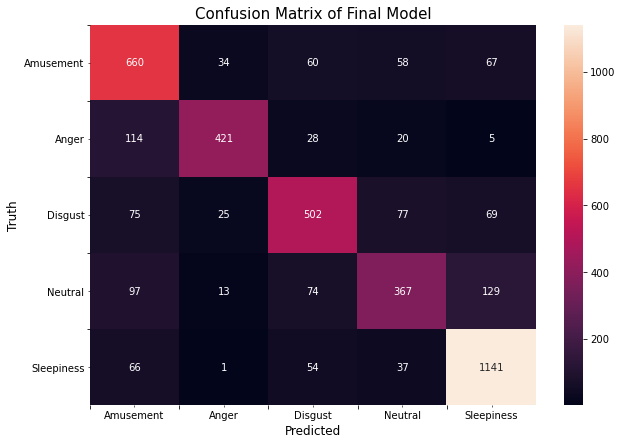

In [25]:
cm =  [[660, 34, 60, 58, 67],\
       [114, 421, 28, 20, 5],\
       [75, 25, 502, 77, 69],\
       [97, 13, 74, 367, 129],\
       [66, 1, 54, 37, 1141]]

classes = ["Amusement", "Anger", "Disgust", "Neutral", "Sleepiness"]

plt.figure(figsize = (10,7))
ax = sns.heatmap(cm, annot = True, fmt='g')
plt.title("Confusion Matrix of Final Model", size=15)
plt.xlabel('Predicted', size=12)
plt.ylabel('Truth', size=12)

ax.set_xticks([0.5,1.5,2.5,3.5,4.5],minor=True)
ax.set_xticklabels(classes, minor=True)
ax.set_yticks([0.5,1.5,2.5,3.5,4.5],minor=True)
ax.set_yticklabels(classes, minor=True)
plt.xticks(tick_marks, '')
plt.yticks(tick_marks, '');
# plt.savefig('images/plots/final_model_cm')

## Future Improvements

In the future, we will more closely balance the input data. While our excess of sleepiness recordings did not seem like much of an issue when modeling began, it became our easiest emotional class to identify. While we were able to take advantage of this shortcoming of our model, to help our client engage even further with their users, it came at the detriment of identifying other emotional classes.

Using our current model as a basis, our client can also collect user sound recordings that can further train our model to continuously improve it. The current model only utilizes four actors with mid-Atlantic accents, thus training with even more users with a variety of accents would make the model more generalizable. 

Additionally, this emotion identification model only works with English speaking users. It would be a massive advantage to expand the training data to other languages, as languages many emphasize different parts of speech than English which will result in massively different spectrographic images.

---
# 6. Appendix
Additional models that were not needed in the main body of the notebook.

## Model 7b - Using 5 Epochs

In [29]:
model_final_5 = tf.keras.models.Sequential()
model_final_5.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_final_5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_final_5.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_final_5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      
model_final_5.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))   
model_final_5.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                    
model_final_5.add(tf.keras.layers.Flatten())                                              
model_final_5.add(tf.keras.layers.Dense(90, activation='relu'))                           
model_final_5.add(tf.keras.layers.Dense(5, activation='softmax'))


model_final_5.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_final_5.summary()


history_final_5 = model_final_5.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=5) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 70)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 35)        

In [30]:
filename = 'model_final_5.pkl'
pickle.dump(model_final_5, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://ffe76888-5237-4978-89f2-bacb1f372c4b/assets


In [31]:
model_final_5.evaluate(test_data)

132/132 [==============================] - 56s 425ms/step - loss: 0.7631 - accuracy: 0.7101


[0.7630651593208313, 0.7100619673728943]

In [5]:
y_pred_final_5 = (model_final_5.predict(test_data)) 
y_true = test_data.classes

y_pred_list_final_5 = []

for i in y_pred_final_5:
    y_pred_list_final_5.append(i.argmax())

# y_df_final_5 = pd.DataFrame({"y_true": y_true, "y_pred_list_final_5":y_pred_list_final_5})
# y_df_final_5

In [35]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list_final_5, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.75      0.50      0.60       879
       Anger       0.78      0.79      0.78       588
     Disgust       0.60      0.63      0.62       748
     Neutral       0.57      0.64      0.60       680
  Sleepiness       0.80      0.90      0.85      1299

    accuracy                           0.71      4194
   macro avg       0.70      0.69      0.69      4194
weighted avg       0.71      0.71      0.71      4194



In [36]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list_final_5))

[[ 443   73  133  124  106]
 [  61  464   28   30    5]
 [  36   40  473  113   86]
 [  29   18  107  435   91]
 [  25    3   45   63 1163]]


## Model 7c - Using 15 Epochs

In [44]:
model_final_15 = tf.keras.models.Sequential()
model_final_15.add(tf.keras.layers.Conv2D(filters=70, kernel_size=3, activation='relu', input_shape=[64,64,3])) 
model_final_15.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
model_final_15.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))  
model_final_15.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                      
model_final_15.add(tf.keras.layers.Conv2D(filters=35, kernel_size=3, activation='relu'))   
model_final_15.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))                    
model_final_15.add(tf.keras.layers.Flatten())                                              
model_final_15.add(tf.keras.layers.Dense(90, activation='relu'))                           
model_final_15.add(tf.keras.layers.Dense(5, activation='softmax'))


model_final_15.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']) 
model_final_15.summary()


history_final_15 = model_final_15.fit(x=train_data, validation_data=val_data, batch_size=45, epochs=15) 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 70)        1960      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 70)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 35)        22085     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 35)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 35)        11060     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 35)        

In [45]:
filename = 'model_final_15.pkl'
pickle.dump(model_final_15, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://69f525a1-55cb-46cf-9547-17a87786c058/assets


In [46]:
model_final_15.evaluate(test_data)

132/132 [==============================] - 56s 421ms/step - loss: 1.1909 - accuracy: 0.7148


[1.1908646821975708, 0.7148306965827942]

In [3]:
y_pred_final_15 = (model_final_15.predict(test_data)) 
y_true = test_data.classes


y_pred_list_final_15 = []

for i in y_pred_final_15:
      y_pred_list_final_15.append(i.argmax())

# y_df_final_15 = pd.DataFrame({"y_true": y_true, "y_pred_list_final_15":y_pred_list_final_15})
# y_df_final_15

In [49]:
class_labels = list(test_data.class_indices.keys())   

print(classification_report(y_true, y_pred_list_final_15, target_names=class_labels)) 

              precision    recall  f1-score   support

   Amusement       0.73      0.57      0.64       879
       Anger       0.88      0.66      0.76       588
     Disgust       0.58      0.67      0.62       748
     Neutral       0.60      0.62      0.61       680
  Sleepiness       0.79      0.91      0.85      1299

    accuracy                           0.71      4194
   macro avg       0.72      0.69      0.70      4194
weighted avg       0.72      0.71      0.71      4194



In [50]:
print(confusion_matrix(y_true=y_true, y_pred=y_pred_list_final_15))

[[ 501   29  155  100   94]
 [  80  390   60   52    6]
 [  44   14  504   96   90]
 [  35   10   94  422  119]
 [  22    0   60   36 1181]]
